In [1]:
%load_ext autoreload

In [29]:
%autoreload 2

import functools as ft
import itertools as it
import json
import math
import operator as op
import os

from IPython.display import display
from ipywidgets import interact, interact_manual, widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import python_speech_features as psf
from scipy import misc, signal, fftpack
from sklearn import metrics
import webrtcvad as wvad

from paprotka.dataset import reddots

%autoreload 0

In [3]:
root = reddots.get_root()
print(root)

load_pcm = ft.partial(reddots.load_pcm, root)

../input/reddots_r2015q4_v1


# Mel Frequency Cepstral Coefficients

Great description of mel frequency cepstral coefficients is [here](http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html). There is also [this](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) post, which the author of the first article bases on.

Filter banks and MFCC are popular features for speech and speaker recognition. MFCC are calculated in the same way as filter banks, but require a few more steps.

We will load a sample file from RedDots to test this on.

In [4]:
sample_sound = load_pcm('m0002/20150713085938321_m0002_31.pcm')

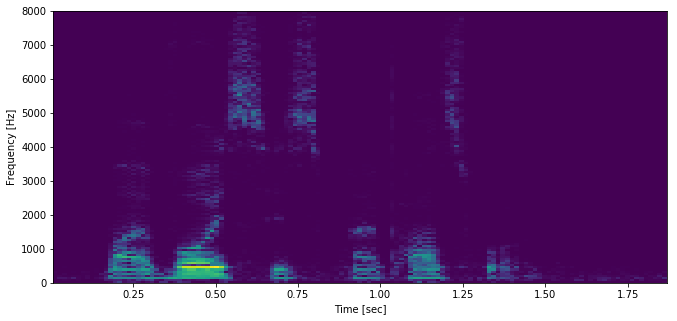

In [5]:
def display_spectrogram(data, rate, result_scaling=np.log1p, view_range=None,
                        xlabel='Time [sec]', ylabel='Frequency [Hz]', 
                        root=None, title=None, show=True, *args, **kwargs):
    if root is None:
        fig, root = plt.subplots()
    if title is not None:
        plt.title(title)
    frequencies, times, spectrogram = signal.spectrogram(data, rate, *args, **kwargs)
    
    if view_range is not None:
        freq_start = np.searchsorted(frequencies, view_range[0], 'left')
        freq_end = np.searchsorted(frequencies, view_range[1], 'right')
        frequencies = frequencies[freq_start:freq_end]
        spectrogram = spectrogram[freq_start:freq_end, :]
    scaled_spectrogram = result_scaling(spectrogram) if result_scaling else spectrogram
    root.pcolormesh(times, frequencies, scaled_spectrogram)
    root.set_xlabel(xlabel)
    root.set_ylabel(ylabel)
    
    if show:
        plt.show()
        
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
display_spectrogram(sample_sound, 16000, root=ax)

## Preemphasis
First the guide mentions that we should apply pre-emphasis, which is just a filtering with $$[-\alpha, 1]$$ where the parameter is usually 0.95 or 0.97. This step emphasizes higher frequency bands and decreases amplitudes of lower frequency bands. It was apparently a numerical trick required in the past and can be skipped now. I will print a frequency characteristic of this simple filter.

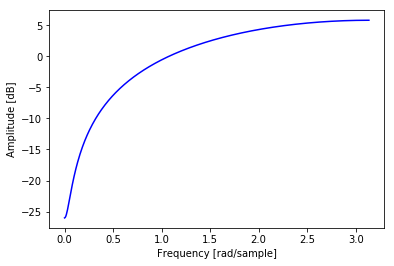

In [6]:
freqz_freqs, freqz_response = signal.freqz([-0.95, 1])

# plt.magnitude_spectrum(freqz_response, freqz_freqs, scale='dB', color='C1')
# plt.show()

plt.plot(freqz_freqs, 20 * np.log10(abs(freqz_response)), 'b')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [rad/sample]')
plt.show()

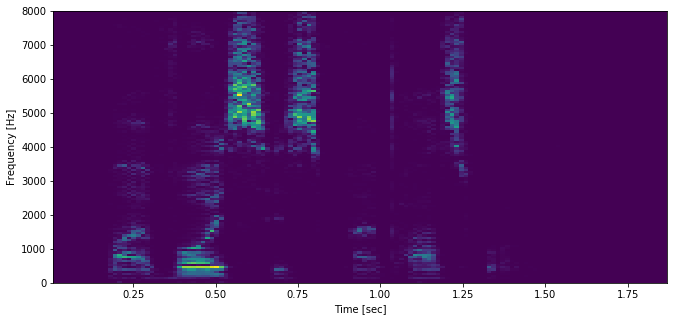

In [7]:
def preemphasize(data, preemphasis=0.95):
    return signal.convolve(data, [-preemphasis, 1]) 

sample_preemphasized = preemphasize(sample_sound, 0.95)

fig, ax = plt.subplots(1, 1, figsize=(11, 5))
display_spectrogram(sample_preemphasized, 16000, root=ax)

## STFT and Power Spectrum
Next (or rather first, since we don't need the preemphasis) we need to divide the signal into windows. This is necessary for the same reason spectrograms are used. To learn how spectrum is changing in time. This operation is also called STFT. (Short Time Fourier Transform)

The linked document recommends using 25ms wide windows with about 50% overlap. Since we have a sampling frequency of 16kHz, we need to take 400 samples per window to get 25ms wide windows. We could pick 512 for 32ms wide windows with a nice property of being a power of two. The overlap of 50% and the Hann window are picked by default in scipy.

Then we will transform the spectra into power spectra by taking the absolute of each complex number and squaring it.

In [8]:
def frame(data, *args, **kwargs):
    return signal.stft(data, 16000, nperseg=512, *args, **kwargs)

def power_spectrum(spectrum):
    return np.abs(spectrum) ** 2
    
sample_stft_freqs, sample_stft_times, sample_stft_transform = frame(sample_sound)
sample_power_spectrum = power_spectrum(sample_stft_transform)

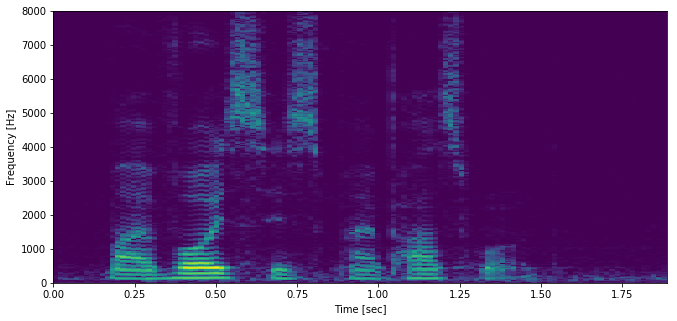

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax.pcolormesh(sample_stft_times, sample_stft_freqs, np.log1p(sample_power_spectrum))
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Frequency [Hz]')
plt.show()

## Bank of Filters

Next step is creating a bank of filters and applying it to the power spectra. The linked guide advises to use about 40 filters. The filters are triangular, with amplitude from 0 to 1, equally distributed in a Mel-scale. Mel-scale is a nonlinear scale that aims to measure how humans perceive sounds. We discern lower frequencies better than higher frequencies and so the same change in mels translates to an increasing change in herzes as the values get greater. The relation to frequency in Hz is as follows:

$$m = 2595 log_{10}(1 + \frac{f}{700})$$
$$f = 700 (10^{m/2595} - 1)$$

In [10]:
def hz_to_mel(hz):
    return 2595 * math.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

def make_mel_filters(half, rate, filter_num):
    min_mel = 0
    max_mel = hz_to_mel(rate / 2)
    mel_points = np.linspace(min_mel, max_mel, filter_num + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((2 * half + 1) * hz_points / rate).astype(np.int32)

    filters = np.zeros((filter_num, half))
    for i in range(filter_num):
        start, mid, end = bin_points[i], bin_points[i + 1], bin_points[i + 2]
        filters[i, start:mid] = np.linspace(0, 1, mid - start, endpoint=False)
        filters[i, mid:end] = np.linspace(1, 0, end - mid, endpoint=True)
    return filters

[ 7  8  9 10 11 13 14 16 18 19 21 24 26 29 32 35 39 43 48 52 57 63 70 77 84
 93]


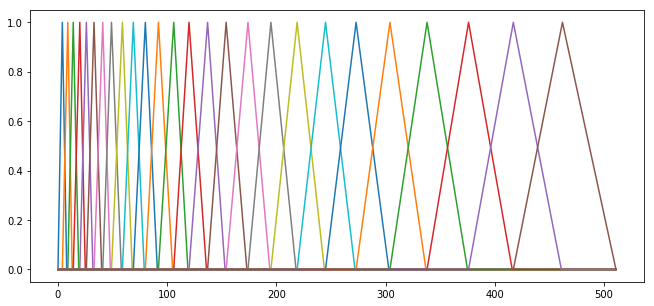

In [18]:
filters = make_mel_filters(512, 16000, filter_num=26)
print((filters != 0).sum(axis=1))

fig, ax = plt.subplots(figsize=(11, 5))
for row in filters:
    ax.plot(row)
plt.xlabel('')
plt.show()

In [28]:
for filter in filters:
    print(filter.nonzero()[0][[0, -1]] * 16000 / filter.size)

[  31.25  218.75]
[ 156.25  375.  ]
[ 312.5  562.5]
[ 468.75  750.  ]
[ 656.25  968.75]
[  843.75  1218.75]
[ 1062.5   1468.75]
[ 1312.5   1781.25]
[ 1562.5   2093.75]
[ 1875.   2437.5]
[ 2187.5  2812.5]
[ 2531.25  3250.  ]
[ 2906.25  3687.5 ]
[ 3343.75  4218.75]
[ 3781.25  4750.  ]
[ 4312.5  5375. ]
[ 4843.75  6031.25]
[ 5468.75  6781.25]
[ 6125.    7593.75]
[ 6875.    8468.75]
[ 7687.5  9437.5]
[  8562.5  10500. ]
[  9531.25  11687.5 ]
[ 10593.75  12968.75]
[ 11781.25  14375.  ]
[ 13062.5  15937.5]


Each filter is applied to a spectrum and the result is summed giving one number per filter - the power in each band covered by a filter. 

Finally we take a logarithm of the coefficients. 

It's possible to use those coefficients as features, but they should be mean normalized. Only one extra step is required to get MFCCs.

In [15]:
def mean_normalize(data):
    means = data.mean(axis=0)
    return data - means

def calculate_filter_bank(data, filter_num=40, *args, **kwargs):
    frequencies, times, transform = signal.stft(data, 16000, nperseg=512, *args, **kwargs)
    power_spectrum = np.abs(transform) ** 2
    filters = make_mel_filters(frequencies.size, 16000, filter_num)
    coefficients = (filters @ power_spectrum).T
    log_coefficients = np.log1p(coefficients)
    return mean_normalize(log_coefficients)

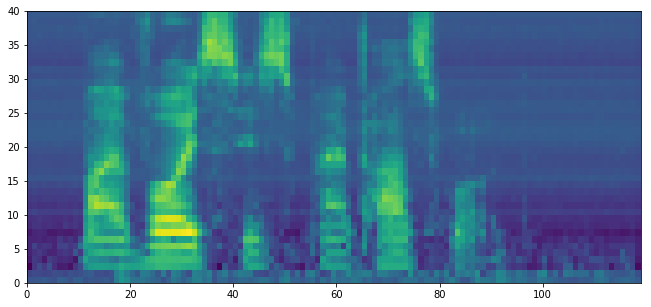

In [16]:
sample_filter_bank = calculate_filter_bank(sample_sound)

fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax.pcolormesh(sample_filter_bank.T)
plt.show()

## MFCC

To get MFCC perform a Discrete Cosine Transform (DCT) on logarithms of coefficients. Then take only several first coefficients (about 12-13) and discard the rest. Then mean normalize as before.

In [17]:
def calculate_mfcc(data, coef_num=15, filter_num=40, *args, **kwargs):
    frequencies, times, transform = signal.stft(data, 16000, nperseg=512, *args, **kwargs)
    power_spectrum = np.abs(transform) ** 2
    filters = make_mel_filters(frequencies.size, 16000, filter_num)
    coefficients = (filters @ power_spectrum).T
    log_coefficients = np.log1p(coefficients)
    mfcc = fftpack.dct(log_coefficients, norm='ortho')
    if coef_num is not None:
        mfcc = mfcc[:, 1:(1 + coef_num)]
    return mean_normalize(mfcc)

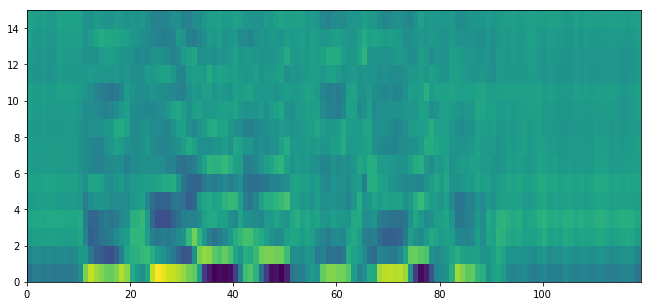

In [18]:
sample_mfcc = calculate_mfcc(sample_sound)

fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax.pcolormesh(sample_mfcc.T)
plt.show()

DCT has whitening (decorellating) effect, good for GMM-HMM. DCT is a linear transformation, discards some nonlinear information. Filter Banks became popular along with neural networks, which don't need uncorrelated data and can learn the nonlinear dependencies that are discarded in MFCC. The decorellation is shown below.

Using MFCCs was necessary with models that require whitened input, in particular GMM-HMMs that were very popular before deep learning. They may not be the best choice with neural networks because some information that networks could learn is discarded.

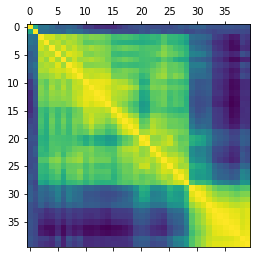

mean 0.450202609214 min 0.0 max 0.990025728268 std 0.330985623067


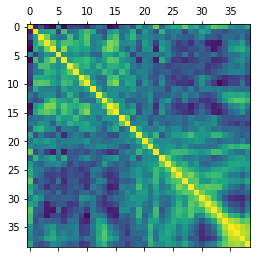

mean 0.246621693682 min 0.0 max 0.917119165529 std 0.186421158665


In [19]:
cov_fb = np.corrcoef(sample_filter_bank.T)
plt.matshow(cov_fb)
plt.show()

cov_fb = np.abs(cov_fb)
np.fill_diagonal(cov_fb, 0)
print('mean', cov_fb.mean(), 'min', cov_fb.min(), 'max', cov_fb.max(), 'std', cov_fb.std())

cov_mfcc = np.corrcoef(calculate_mfcc(sample_sound, coef_num=40).T)
plt.matshow(cov_mfcc)
plt.show()

cov_mfcc = np.abs(cov_mfcc)
np.fill_diagonal(cov_mfcc, 0)
print('mean', cov_mfcc.mean(), 'min', cov_mfcc.min(), 'max', cov_mfcc.max(), 'std', cov_mfcc.std())

In [33]:
def transform_all_recordings(root, source, target, function, *args, **kwargs):
    for person_dir in os.listdir(os.path.join(root, source)):
        source_dir = os.path.join(root, source, person_dir)
        target_dir = os.path.join(root, target, person_dir)
        
        os.makedirs(target_dir)
        for source_file in os.listdir(source_dir):
            target_file = source_file if source != 'pcm' else source_file[:-3] + 'npy'
            
            source_path = os.path.join(source_dir, source_file)
            target_path = os.path.join(target_dir, source_file)
            
            if source == 'pcm':
                source_data = np.fromfile(source_path, np.int16)
            else: 
                source_data = np.load(source_path)
                
            result = function(source_data, *args, **kwargs)
            
            np.save(target_path, result)

In [54]:
transform_all_recordings(root, 'pcm', 'fbank_default', lambda signal: psf.fbank(signal)[0])

In [47]:
transform_all_recordings(root, 'pcm', 'mfcc_default', psf.mfcc)

## Delta features

> Delta calculation at ICSI almost always means convolving the time sequence of each feature dimension with a 9-point impulse response that goes linearly from +4 to -4 (modulo a scale factor). This isn't strictly a differentiator, but does (I think) result in a least-squares linear fit to the points within the window.

In [48]:
def make_delta_ddelta(signal):
    deltas = psf.delta(signal, 4)
    ddeltas = psf.delta(deltas, 4)
    return np.hstack((signal, deltas, ddeltas))

In [52]:
transform_all_recordings(root, 'mfcc_default', 'mfcc_default_d_dd', make_delta_ddelta)

## Voice Activity Detection

In [42]:
def trim_silent(signal, rate=16000, duration=20, aggro_mode=1):
    length = len(signal)
    width = rate * duration // 1000
    vad = wvad.Vad(aggro_mode)
    
    start_offset = 0
    for start in range(0, length - width, width):
        frame = signal[start:start + width]
        is_speech = vad.is_speech(frame, 16000)
        if is_speech:
            start_offset = start
            break
            
    end_offset = length
    for end in range(length, width, -width):
        frame = signal[end - width:end]
        is_speech = vad.is_speech(frame, 16000)
        if is_speech:
            end_offset = end
            break
    
    return signal[start_offset:end_offset]
    
print(len(sample_sound), len(trim_silent(sample_sound, aggro_mode=1)))

30080 30080


In [45]:
transform_all_recordings(root, 'pcm', 'wac2', trim_silent, aggro_mode=2)

In [51]:
transform_all_recordings(root, 'wac1', 'wac1_mfcc13', psf.mfcc, numcep=13)

In [52]:
transform_all_recordings(root, 'wac2', 'wac2_mfcc13', psf.mfcc, numcep=13)

In [53]:
transform_all_recordings(root, 'wac1_mfcc13', 'wac1_mfcc13_ddd', make_delta_ddelta)
transform_all_recordings(root, 'wac2_mfcc13', 'wac2_mfcc13_ddd', make_delta_ddelta)

# Perceptual Linear Prediction

Based on Linear Predictive Coding.

# i-vectors

# Joint Factor Analysis (of i-vectors)

# NSynth

I found it described in [this blog post](https://medium.com/@LeonFedden/comparative-audio-analysis-with-wavenet-mfccs-umap-t-sne-and-pca-cb8237bfce2f).